In [2]:
import duckdb

with duckdb.connect("data/sakila.duckdb") as conn:
    description = conn.sql("DESC;").df()

dfs = {}

with duckdb.connect("data/sakila.duckdb") as conn:
    for name in description["name"]:
        if name[0] != "_":
            dfs[name] = conn.sql(f"FROM staging.{name};").df()
            duckdb.register(name, dfs[name])

TASK 1

In [ ]:
# a)

a = duckdb.sql("""--sql
               SELECT 
                title,
                length 
               FROM film 
               WHERE length > 180
               ORDER BY length DESC;""").df()
a.head()

,title,length
0,WORST BANGER,185
1,CHICAGO NORTH,185
2,CONTROL ANTHEM,185
3,DARN FORRESTER,185
4,SWEET BROTHERHOOD,185


: 

In [ ]:
# b)

b = duckdb.sql("""--sql
               SELECT 
                title, 
                rating, 
                length, 
                description 
               FROM film 
               WHERE REGEXP_MATCHES(title, '(^| )LOVE($| )');""").df()
b

,title,rating,length,description
0,GRAFFITI LOVE,PG,117,A Unbelieveable Epistle of a Sumo Wrestler And...
1,IDAHO LOVE,PG-13,172,A Fast-Paced Drama of a Student And a Crocodil...
2,INDIAN LOVE,NC-17,135,A Insightful Saga of a Mad Scientist And a Mad...
3,LAWRENCE LOVE,NC-17,175,A Fanciful Yarn of a Database Administrator An...
4,LOVE SUICIDES,R,181,A Brilliant Panorama of a Hunter And a Explore...


: 

In [ ]:
# c)
c = duckdb.sql("""--sql
               SELECT 
                MIN(length) AS shortest_film, 
                MAX(length) AS longest_film, 
                AVG(length) AS average_length, 
                MEDIAN(length) AS median_length 
               FROM film;""").df()
c

,shortest_film,longest_film,average_length,median_length
0,46,185,115.272,114.0


: 

In [ ]:
# d)
d = duckdb.sql("""--sql
               SELECT 
                title, 
                rental_rate/rental_duration AS adjusted_rate 
               FROM film 
               ORDER BY adjusted_rate DESC 
               LIMIT 10;""").df()
d

,title,adjusted_rate
0,AMERICAN CIRCUS,1.663333
1,BACKLASH UNDEFEATED,1.663333
2,BILKO ANONYMOUS,1.663333
3,BEAST HUNCHBACK,1.663333
4,CARIBBEAN LIBERTY,1.663333
5,AUTUMN CROW,1.663333
6,CASPER DRAGONFLY,1.663333
7,ACE GOLDFINGER,1.663333
8,BEHAVIOR RUNAWAY,1.663333
9,CASUALTIES ENCINO,1.663333


: 

In [ ]:
# e)
e = duckdb.sql("""--sql
               SELECT 
                fa.actor_id,
                a.first_name,
                a.last_name,
               COUNT(fa.film_id) AS frequency 
               FROM actor a 
               LEFT JOIN film_actor fa ON a.actor_id = fa.actor_id 
               GROUP BY fa.actor_id, a.first_name, a.last_name 
               ORDER BY frequency DESC 
               LIMIT 10;""").df()
e

,actor_id,first_name,last_name,frequency
0,107,GINA,DEGENERES,42
1,102,WALTER,TORN,41
2,198,MARY,KEITEL,40
3,181,MATTHEW,CARREY,39
4,23,SANDRA,KILMER,37
5,81,SCARLETT,DAMON,36
6,158,VIVIEN,BASINGER,35
7,144,ANGELA,WITHERSPOON,35
8,106,GROUCHO,DUNST,35
9,37,VAL,BOLGER,35


: 

In [ ]:
# Which films in the film list does not exist in the inventory?

missing_id = duckdb.sql("""--sql
                        SELECT film_id FROM film
                        EXCEPT 
                        SELECT film_id FROM inventory
                        ORDER BY film_id;""").df()

print(missing_id.values.flatten())

[ 14  33  36  38  41  87 108 128 144 148 171 192 195 198 217 221 318 325
 332 359 386 404 419 495 497 607 642 669 671 701 712 713 742 801 802 860
 874 909 943 950 954 955]


: 

In [ ]:
# Which actors might be more lucrative?

lucrative_actors = duckdb.sql("""--sql
                                SELECT a.actor_id,
                                 CONCAT(a.first_name, ' ', a.last_name) AS full_name,
                                 SUM(p.amount) AS amount
                                FROM actor a
                                LEFT JOIN film_actor fa ON a.actor_id = fa.actor_id
                                LEFT JOIN film f ON fa.film_id = f.film_id
                                LEFT JOIN inventory i ON f.film_id = i.film_id
                                LEFT JOIN rental r ON i.inventory_id = r.inventory_id
                                LEFT JOIN payment p ON r.rental_id = p.rental_id
                                GROUP BY a.actor_id,full_name
                                ORDER BY amount DESC;""").df()

lucrative_actors.head()

,actor_id,full_name,amount
0,107.0,GINA DEGENERES,3442.49
1,181.0,MATTHEW CARREY,2742.19
2,198.0,MARY KEITEL,2689.25
3,81.0,SCARLETT DAMON,2655.28
4,102.0,WALTER TORN,2620.62


: 

In [5]:
# In case a store burns down the insurance company want data on the sum of the replacement costs of the films in each store

sum_replacement_cost = duckdb.sql("""--sql
                                SELECT 
                                 s.address_id,
                                 sum(f.replacement_cost)
                                FROM store s
                                LEFT JOIN inventory i ON s.store_id = i.store_id
                                LEFT JOIN film f ON i.film_id = f.film_id
                                GROUP BY address_id;""").df()

sum_replacement_cost

,address_id,sum(f.replacement_cost)
0,2,46415.89
1,1,46205.30


In [4]:
# The head of business development wants to know which countries make up the majority of sales for future expansions

revenue_by_country = duckdb.sql("""--sql
                                SELECT 
                                 co.country,
                                 sum(p.amount) AS amount
                                FROM country co
                                LEFT JOIN city ci ON ci.country_id = co.country_id
                                LEFT JOIN address a ON a.city_id = ci.city_id
                                LEFT JOIN customer cu ON cu.address_id = a.address_id
                                LEFT JOIN payment p ON p.customer_id = cu.customer_id
                                GROUP BY co.country
                                ORDER BY amount DESC;""").df()  

revenue_by_country.head()

,country,amount
0,India,6630.27
1,China,5802.73
2,United States,4110.32
3,Japan,3471.74
4,Mexico,3307.04


In [ ]:
# HR wants data on the performance of the employees, measured by sum of payments

sum_of_amount = duckdb.sql("""--sql
                            SELECT
                             s.first_name,
                             SUM(p.amount) AS sum
                            FROM
                            staff s
                            LEFT JOIN payment p ON s.staff_id = p.staff_id
                            GROUP BY s.first_name;""").df()
sum_of_amount

,first_name,sum
0,Jon,33927.04
1,Mike,33489.47


: 

In [ ]:
# HR wants data on the performance of the employees, measured by number of unique transactions made

number_unique_payments = duckdb.sql("""--sql
                                    SELECT
                                     s.first_name,
                                     COUNT(payment_id)
                                    FROM
                                    staff s
                                    LEFT JOIN payment p ON s.staff_id = p.staff_id
                                    GROUP BY s.first_name;""").df()

number_unique_payments

,first_name,count(payment_id)
0,Jon,7992
1,Mike,8057


: 

Task 2

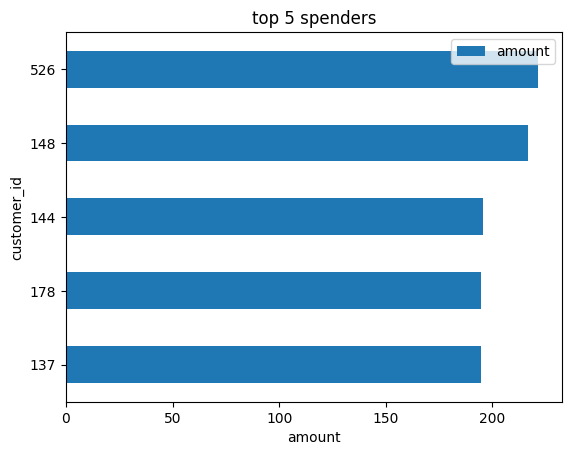

: 

In [ ]:
# a)
top_spender = duckdb.sql("""--sql
                         SELECT customer_id,
                          SUM(amount) AS amount 
                         FROM payment 
                         GROUP BY customer_id 
                         ORDER BY amount DESC;""").df()
ax = top_spender.head(5).plot(
    kind="barh",
    x="customer_id",
    y="amount",
    title="top 5 spenders",
    xlabel="amount",
)
ax.invert_yaxis()

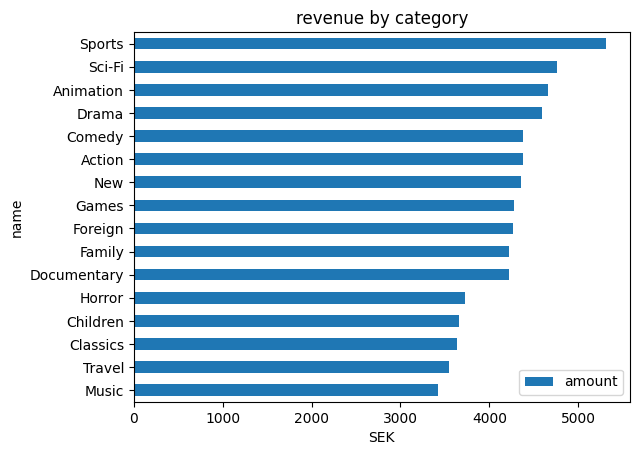

: 

In [ ]:
# b)
revenue_category = duckdb.sql("""--sql
                                SELECT c.name,
                                 SUM(p.amount) AS amount 
                                FROM category c
                                LEFT JOIN film_category fc ON c.category_id = fc.category_id
                                LEFT JOIN film f ON fc.film_id = f.film_id
                                LEFT JOIN inventory i ON f.film_id = i.film_id
                                LEFT JOIN rental r ON i.inventory_id = r.inventory_id
                                LEFT JOIN payment p ON r.rental_id = p.rental_id
                                GROUP BY c.name
                                ORDER BY amount DESC;""").df()

ax = revenue_category.plot(
    kind="barh",
    x="name",
    y="amount",
    title="revenue by category",
    xlabel="SEK",
)
ax.invert_yaxis()